In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import gensim

data = pd.read_json("dataWithTags.json")
data['created_at'] = pd.to_datetime(data.created_at, format="%Y-%m-%d %H:%M:%S")
data.sort_values(by=['created_at'], inplace=True, ascending=True)
data.reset_index(inplace=True,drop=True)

data['month'] = [d.month for d in data['created_at']]
data["year"] = [d.year for d in data["created_at"]]
data["hour"] = [d.hour for d in data["created_at"]]
data["week_year"] = [d.weekofyear for d in data["created_at"]]
data["date"] = [d.date() for d in data["created_at"]]

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stemmedTweets = []

for idx, row in data.iterrows():
    test = row["modded_text"].split()
    desc = ""
    for el in test:
        desc = desc + " " + stemmer.stem(el) + " "
    stemmedTweets.append(desc)
temp = pd.Series(stemmedTweets)
data["stemmed"] = temp

#remove stopwords
import nltk
from nltk.corpus import stopwords

stop = stopwords.words('english')

data['stemmed'] = data['stemmed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data["noStop_modded"] = data['modded_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data.head()

E:\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,modded_text,@johnboehner,...,@mattginellagc,@foxandfriends,@cnn,month,year,hour,week_year,date,stemmed,noStop_modded
0,2009-05-04 18:54:25,202,1698308935,NaN,False,253,Twitter Web Client,Be sure to tune in and watch Donald Trump on L...,be sure to tune in and watch donald trump on l...,0,...,0,0,0,5,2009,18,19,2009-05-04,sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...
1,2009-05-05 01:00:10,3,1701461182,NaN,False,2,Twitter Web Client,Donald Trump will be appearing on The View tom...,donald trump will be appearing on the view tom...,0,...,0,0,0,5,2009,1,19,2009-05-05,donald trump appear view tomorrow morn discuss...,donald trump appearing view tomorrow morning d...
2,2009-05-08 13:38:08,2,1737479987,NaN,False,3,Twitter Web Client,Donald Trump reads Top Ten Financial Tips on L...,donald trump reads top ten financial tips on l...,0,...,0,0,0,5,2009,13,19,2009-05-08,donald trump read top ten financi tip late sho...,donald trump reads top ten financial tips late...
3,2009-05-08 20:40:15,27,1741160716,NaN,False,8,Twitter Web Client,New Blog Post: Celebrity Apprentice Finale and...,new blog post celebrity apprentice finale and ...,0,...,0,0,0,5,2009,20,19,2009-05-08,new blog post celebr apprentic final lesson le...,new blog post celebrity apprentice finale less...
4,2009-05-12 14:07:28,1950,1773561338,NaN,False,1421,Twitter Web Client,"""My persona will never be that of a wallflower...",my persona will never be that of a wallflower ...,0,...,0,0,0,5,2009,14,20,2009-05-12,persona never wallflow id rather build wall cl...,persona never wallflower id rather build walls...


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import scipy.sparse as sp
from scipy.sparse import hstack
import numpy as np


(3459, 8258)


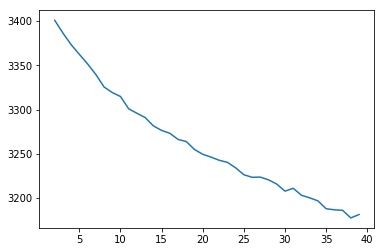

In [4]:
data1 = data[data["year"] == 2018]
vect = TfidfVectorizer()
x = vect.fit_transform(data1['noStop_modded'])
print(x.shape)
df = pd.DataFrame(x.toarray() , columns = vect.get_feature_names())

#sse_list = list()
#max_k = 40
#plt.figure((12,6))
#for k in range(2,max_k):
 #   kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
  #  kmeans.fit(df)
   # sse = kmeans.inertia_
    #sse_list.append(sse)
#plt.plot(range(2,max_k), sse_list)
#plt.show()

In [22]:
#è fottuta? 
#print(vect.vocabulary_)
#print(vect.idf_)
true_k = 15
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
print(model.inertia_)
#con l'ultima maniera è più bassa di 1000 rispetto a fede, viene tipo 2400 alei 3800
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print
#3170

3277.5171724239735
Top terms per cluster:
Cluster 0:
 hunt
 witch
 collusion
 fbi
 hillary
 russia
 democrats
 mueller
 rigged
 crooked
Cluster 1:
 jobs
 unemployment
 economy
 numbers
 since
 ever
 lowest
 market
 level
 better
Cluster 2:
 news
 fake
 media
 cnn
 people
 amp
 great
 enemy
 much
 story
Cluster 3:
 trade
 us
 china
 tariffs
 countries
 deal
 fair
 barriers
 canada
 united
Cluster 4:
 rt
 realdonaldtrump
 president
 whitehouse
 scavino45
 trump
 erictrump
 potus
 hurricane
 flotus
Cluster 5:
 forward
 maga
 tonight
 interviewed
 enjoy
 foxnews
 look
 pm
 looking
 see
Cluster 6:
 america
 great
 make
 making
 together
 first
 business
 open
 thank
 winning
Cluster 7:
 democrats
 want
 house
 republicans
 daca
 white
 dont
 dems
 court
 supreme
Cluster 8:
 crime
 vets
 endorsement
 strong
 military
 loves
 amendment
 great
 borders
 total
Cluster 9:
 korea
 north
 kim
 un
 jong
 meeting
 summit
 good
 nuclear
 singapore
Cluster 10:
 trump
 people
 president
 amp
 great
 co

In [24]:
from sklearn.metrics import silhouette_score
silhouette_score(df, model.labels_)
#0.0146

0.010996286994720694

In [10]:
data1['label_kmeans'] = model.labels_
data1

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,modded_text,@johnboehner,...,@foxandfriends,@cnn,month,year,hour,week_year,date,stemmed,noStop_modded,label_kmeans
32790,2018-01-01 12:12:00,138808,947802588174577664,NaN,False,49566,Twitter for iPhone,The United States has foolishly given Pakistan...,the united states has foolishly given pakistan...,0,...,0,0,1,2018,12,1,2018-01-01,unit state ha foolishli given pakistan 33 bill...,united states foolishly given pakistan 33 bill...,11
32791,2018-01-01 12:44:40,53557,947810806430826496,25073877.0,False,14595,Twitter for iPhone,Iran is failing at every level despite the ter...,iran is failing at every level despite the ter...,0,...,0,0,1,2018,12,1,2018-01-01,iran fail everi level despit terribl deal made...,iran failing every level despite terrible deal...,17
32792,2018-01-01 13:37:52,51473,947824196909961216,NaN,False,8237,Twitter for iPhone,Will be leaving Florida for Washington (D.C.) ...,will be leaving florida for washington dc toda...,0,...,0,0,1,2018,13,1,2018-01-01,leav florida washington dc today 400 pm much w...,leaving florida washington dc today 400 pm muc...,6
32793,2018-01-09 23:07:09,82151,950866561153331200,NaN,False,19481,Twitter for iPhone,"Today, it was my great honor to sign a new Exe...",today it was my great honor to sign a new exec...,0,...,0,0,1,2018,23,2,2018-01-09,today wa great honor sign new execut order ens...,today great honor sign new executive order ens...,9
32794,2018-01-09 23:59:38,0,950879772644659200,NaN,True,11716,Twitter for iPhone,"RT @Scavino45: “Utilities cutting rates, cite ...",rt scavino45 utilities cutting rates cite bene...,0,...,0,0,1,2018,23,2,2018-01-09,rt scavino45 util cut rate cite benefit trump ...,rt scavino45 utilities cutting rates cite bene...,0
32795,2018-01-10 00:16:57,123413,950884128379035648,NaN,False,24552,Twitter for iPhone,"As I made very clear today, our country needs ...",as i made very clear today our country needs t...,0,...,0,0,1,2018,0,2,2018-01-10,made veri clear today countri need secur wall ...,made clear today country needs security wall s...,3
32796,2018-01-10 03:48:26,51951,950937350003183616,NaN,False,11893,Twitter for iPhone,Thank you @GOPLeader Kevin McCarthy! Couldn’t ...,thank you gopleader kevin mccarthy couldnt agr...,0,...,0,0,1,2018,3,2,2018-01-10,thank goplead kevin mccarthi couldnt agre wyou...,thank gopleader kevin mccarthy couldnt agree w...,35
32797,2018-01-10 04:23:58,60252,950946293077209088,NaN,False,13822,Twitter for iPhone,".@ICEgov HSI agents and ERO officers, on behal...",icegov hsi agents and ero officers on behalf o...,0,...,0,0,1,2018,4,2,2018-01-10,icegov hsi agent ero offic behalf entir nation...,icegov hsi agents ero officers behalf entire n...,29
32798,2018-01-10 14:11:13,108152,951094078661414912,NaN,False,26665,Twitter for iPhone,It just shows everyone how broken and unfair o...,it just shows everyone how broken and unfair o...,0,...,0,0,1,2018,14,2,2018-01-10,show everyon broken unfair court system oppos ...,shows everyone broken unfair court system oppo...,33
32799,2018-01-10 15:00:29,92227,951106475254059008,NaN,False,22740,Twitter for iPhone,"The fact that Sneaky Dianne Feinstein, who has...",the fact that sneaky dianne feinstein who has ...,0,...,0,0,1,2018,15,2,2018-01-10,fact sneaki diann feinstein ha numer occas sta...,fact sneaky dianne feinstein numerous occasion...,27


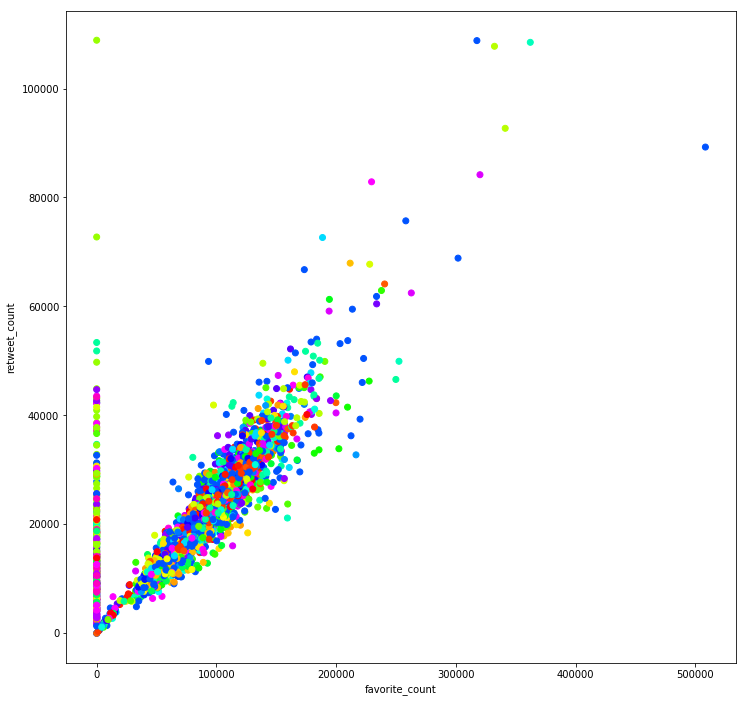

In [15]:
plt.figure(figsize=(12, 12)) 
plt.scatter(x=data1['favorite_count'], y=data1['retweet_count'], 
            c=data1['label_kmeans'], cmap='gist_rainbow')
plt.xlabel('favorite_count')
plt.ylabel('retweet_count')
#plt.legend()
plt.show()
